# MAP Inpainter - grayscale

In [2]:
%load_ext autoreload
%autoreload 2

from utils import *

%matplotlib inline
import matplotlib.pyplot as plt

#%env CUDA_VISIBLE_DEVICES=1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MAP Denoiser

### Train MAP Denoiser
(skip if you want to use the provided model)  

In [ ]:
from MAPdenoiser import MAPdenoiser
DAE = MAPdenoiser(stddev=7.0/255., channels=1)

In [ ]:
DAE.train(epoch = 50, batch_size = 128, lr = 0.0001, phase = "train",
          ckpt_dir = './models/map_gray', sample_dir ='./sample', test_dir ='./test',
          dataset_path = './data/img_clean_pats.npy', eval_set ='Set12', test_set ='Set12',
          eval_every_epoch=1)

[*] Initialize model successfully...
[*] Loading data...
[*] Load successfully...
[*] Reading checkpoint...
[*] Not find pretrained model!
[*] Start training, with start epoch 0 start iter 0 : 
[*] Evaluating...
--- Test ---- Average PSNR 53.53 ---


In [ ]:
DAE.freeze_graph(ckpt_dir = './models/map_gray')

## Inpainting

### Test image + test kernel

/local/user/dho/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/local/user/dho/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


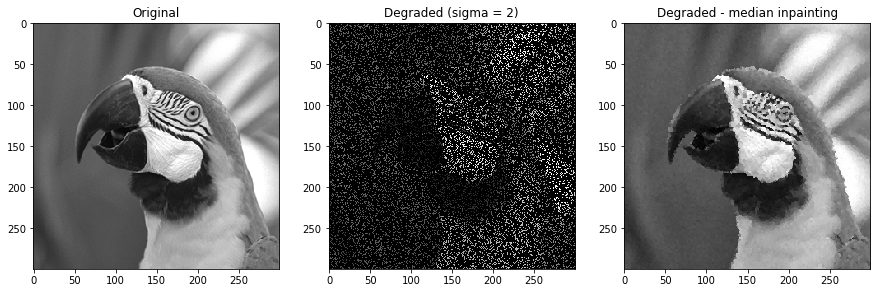

In [4]:
np.random.seed(0)

sigma_d = 255 * .01

fig = plt.figure(figsize=(15, 5))

gt = np.array(Image.open('./data/images/kodim23.png').convert('L'), dtype='float32')
gt = gt[120:420,20:320,None]
plt.subplot(131)
plt.title("Original")
plt.imshow(np.squeeze(gt / 255), cmap="gray")

degraded, mask = drop_and_noise(gt, sigma_d, 0.8)
initial = median_inpainting(degraded, mask) 

img_degraded = Image.fromarray(np.clip(np.squeeze(degraded), 0, 255).astype(dtype=np.uint8))
img_initial = Image.fromarray(np.clip(np.squeeze(initial), 0, 255).astype(dtype=np.uint8))
#img_degraded.save("data/degraded.png","png")

plt.subplot(132)
plt.imshow(np.squeeze(img_degraded), cmap="gray")
plt.title("Degraded (sigma = %d)" % sigma_d)

plt.subplot(133)
plt.imshow(np.squeeze(img_initial), cmap="gray")
plt.title("Degraded - median inpainting")

plt.show() 

### Optimization

iteration 4, PSNR is: 25.9976, iteration finished in 0.06 s
iteration 9, PSNR is: 26.4764, iteration finished in 0.05 s
iteration 14, PSNR is: 26.8272, iteration finished in 0.05 s
iteration 19, PSNR is: 27.1118, iteration finished in 0.05 s
iteration 24, PSNR is: 27.3532, iteration finished in 0.05 s
iteration 29, PSNR is: 27.5601, iteration finished in 0.05 s
iteration 34, PSNR is: 27.7361, iteration finished in 0.05 s
iteration 39, PSNR is: 27.8909, iteration finished in 0.05 s
iteration 44, PSNR is: 28.0234, iteration finished in 0.05 s
iteration 49, PSNR is: 28.1406, iteration finished in 0.06 s
iteration 54, PSNR is: 28.2458, iteration finished in 0.05 s
iteration 59, PSNR is: 28.3376, iteration finished in 0.05 s
iteration 64, PSNR is: 28.4199, iteration finished in 0.05 s
iteration 69, PSNR is: 28.4953, iteration finished in 0.05 s
iteration 74, PSNR is: 28.5606, iteration finished in 0.05 s
iteration 79, PSNR is: 28.6226, iteration finished in 0.05 s
iteration 84, PSNR is: 28.

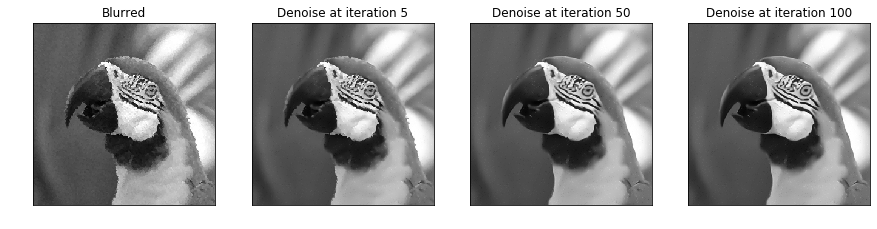

In [26]:
from MAPinpainting import MAPinpainting
sigma_dae = 7
rho = 1 / (sigma_dae**2) # small pertrubation to the rho might help the convergence (default 1 / (sigma_dae**2))

inpainter = MAPinpainting(rho, sigma_d, initial.shape,
                           denoiser = './models/map_gray/optimizedMAPdenoiser.pb')

res = inpainter.optimize(initial, mask, gt, nr_iters=100, test_iter=5, plot=True)